# EMCEE: fitting a line with scatter

This notebooks shows the solution for the exercise V.2.3 (fitting a straight line with scatter)


## Set up the code

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Creating the data for the purpose of the exercise

This is our starting point but is NOT part of the exercise. We just create here fake data such that we know what was in.

<Container object of 3 artists>

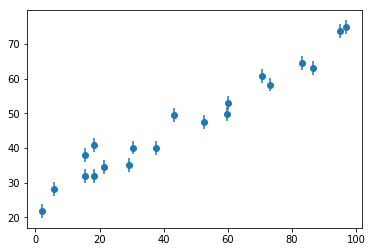

In [2]:
def make_data_scatter(intercept, slope, scatter, N=20, dy=2, rseed=42):
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(20)
    y = intercept + slope * x
    y += np.sqrt(dy ** 2 + scatter ** 2) * rand.randn(20)
    return x, y, dy * np.ones_like(x)

theta_truth = (25, 0.5, 3.0)  # (intercept, slope, intrinsic scatter)
x, y, dy = make_data_scatter(*theta_truth)
plt.errorbar(x, y, dy, fmt='o')

### Step 1: defining posterior, likelihood, prior

Remember that we need to implement the following likelihood: 

$$
P(D\mid\boldsymbol{\theta}) =  \prod_{i=1}^{N} \frac{1}{\sqrt{2\,\pi (\sigma_i^2 + \sigma^2)}} \, \exp\left[\left (\frac{ -(y_i - (\theta_0+\theta_1\,x_i))^2}{2\,(\sigma_i^2+\sigma^2)} \right)\right]
$$

Translated in python (and taking the ln) this is expressed: 

``` python
def ln_likelihood(theta, x, y, dy):
    y_model = theta[0] + theta[1] * x
    S = dy ** 2 + theta[2] ** 2
    return -0.5 * np.sum(np.log( 2 * np.pi * S ) 
                                + (y - y_model) ** 2 / S ) 
```

On the other hand the prior for the scatter is:

$$
P(\sigma)\propto\sigma^{-1}
$$

and the prior on the slope is(symmetric prior):
$$
P(\theta_1) \propto (1 + \theta_1^2)^{-3/2}
$$

Translated into a python function, this will be:
``` python
def ln_prior(theta):
    if ((np.abs(theta[0]) < 1000) & ( theta[2] > 0)) :
        return -1.5 * np.log(1 + theta[1] ** 2) + np.log(1./theta[2])
    else:
        return -np.inf  # log(0)
```

In [3]:
# Define functions to compute the log-prior, log-likelihood, and log-posterior

# theta = [intercept, slope, scatter]

def ln_prior(theta):
    if ((np.abs(theta[0]) < 1000) & ( theta[2] > 0)) :
        return -1.5 * np.log(1 + theta[1] ** 2) + np.log(1./theta[2])
    else:
        return -np.inf  # log(0)
    
def ln_likelihood(theta, x, y, dy):
    y_model = theta[0] + theta[1] * x
    S = dy ** 2 + theta[2] ** 2
    return -0.5 * np.sum(np.log( 2 * np.pi * S ) 
                                + (y - y_model) ** 2 / S ) 

def ln_posterior(theta, x, y, dy):
    return ln_prior(theta) + ln_likelihood(theta, x, y, dy)                                


### Step 2: Sampling the posterior with EMCEE

In [4]:
import emcee

ndim = 3  # number of parameters in the model
nwalkers = 100  # number of MCMC walkers

# initialize walkers
starting_guesses = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=[x, y, dy])

pos, prob, state = sampler.run_mcmc(starting_guesses, 1000)

/home/dominis/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/dominis/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


### Step 3: plotting the chains

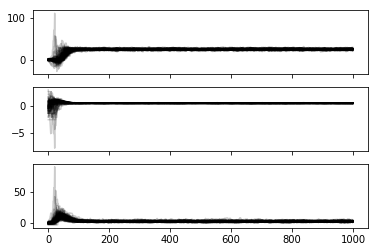

In [5]:
# Plotting the chains

fig, ax = plt.subplots(3, sharex=True)
for i in range(3):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2)

### Step 4: Restarting after burn-in

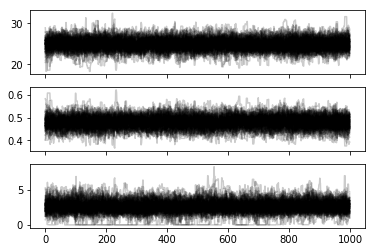

In [6]:
# Restarting after burn in 

# Are your chains stabilized? Reset them and get a clean sample

sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000)

fig, ax = plt.subplots(3, sharex=True)
for i in range(3):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2)


### Step 5: Visualizing

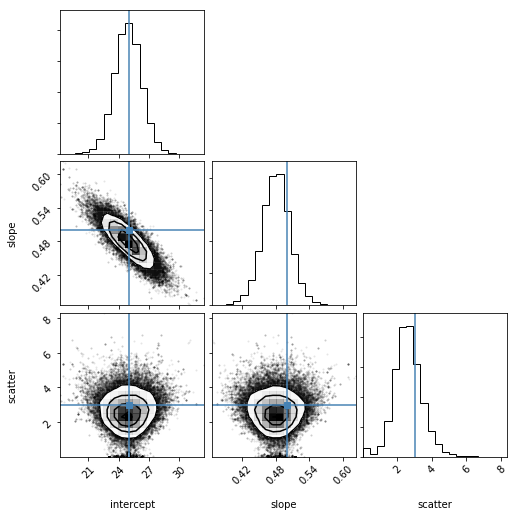

In [7]:
import corner
qq = corner.corner(sampler.flatchain, truths=theta_truth, labels=['intercept', 'slope', 'scatter'])

In [10]:
# Alternative visualisation without using corner
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])   # x bin centers = (xright+xleft) / 2
    ybins = 0.5 * (ybins[1:] + ybins[:-1])   # y bin centers

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)

def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')

def plot_MCMC_model(ax, xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ok')

    alpha, beta = trace[:2]
    xfit = np.linspace(-20, 120, 10)
    yfit = alpha[:, None] + beta[:, None] * xfit
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')

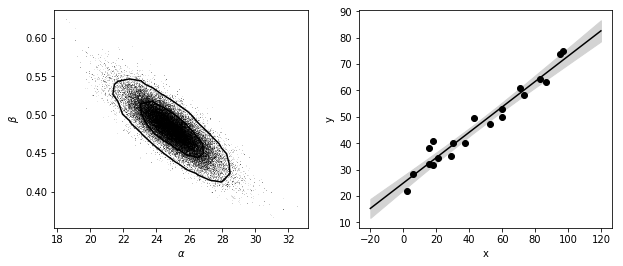

In [11]:
def plot_MCMC_results(xdata, ydata, trace, colors='k'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace)
    
nburn=200
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
plot_MCMC_results(x, y, emcee_trace)

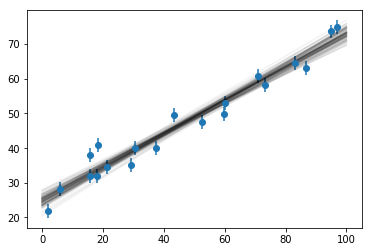

In [12]:
chain = sampler.flatchain

plt.errorbar(x, y, dy, fmt='o');

thetas = [chain[i] for i in np.random.choice(chain.shape[0], 100)]  # Take 100 values from the final chain

xfit = np.linspace(0, 100)
for i in range(100):
    theta = thetas[i]
    plt.plot(xfit, theta[0] + theta[1] * xfit, color='black', alpha=0.05)